# agglomerative_CNN_clustering
- In [CNN_transfer_learning](./CNN_transfer_learning), we used a pre-trained convolutional neural network to generate a new feature set to better represent the galaxy images. These features were then compressed by a principal component analysis.
- In [kmeans_CNN_clustering](./kmeans_CNN_clustering.ipynb), we did a basic grouping into 10 clusters. Since there is not really a _good_ answer for how many clusters of galaxies we should have, so now lets try an algorithm that dictates the number of clusters.
- In [affinity_propagation_CNN_clustering](./affinity_propagation_CNN_clustering.ipynb), we used affinity propagation to automatically generate the clusters (and hence number and sizes). Using the higher dimensionality parameter space (i.e. output from CNN compress by the pca), we find that the process results in very precise clusters! The visual similarity is striking, however, is clustering based on postion angle (i.e. which direction the galaxy is pointing), colour, spiral (or other) structure and size/footprint of the galaxy in the image. Connecting these clusters is the difficult part, since many may simply be the same catagory/type of galaxy but viewed in a different way (position angle or footprint).
- To help aid this, we now look to hierarchical clustering (i.e. agglomerative - bottom-up) clustering to help define several levels of similarity (i.e, using ~175 clusters as a starting point).

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import harry_plotter
import itertools
from matplotlib import rcParams, gridspec
harry_plotter.default(rcParams)

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
import cluster_evaluate

# default dendrogram colour params
cmap = plt.cm.coolwarm(np.linspace(0.3, 2, 10))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

### Loading set of features 
- Also weights in case we want to manipulate feature space to rank pca components that best describe the variance in the data
- Several feature representations were generated, so selecting combination of output features from CNN and the number of features these were compressed to by the pca.

In [2]:
pca_feat = 100
cnn_feat = 37632

features = np.load('./features/CNN-' + str(cnn_feat) + '_PCA-' + str(pca_feat) + '_features.npy')
weights = np.load('./features/CNN-' + str(cnn_feat) + '_PCA-' + str(pca_feat) + '_weights.npy')

plot_path = './cluster_plots/agglomerative/CNN-' + str(cnn_feat) + '_PCA-' + str(pca_feat) +'/'
plot_path

'./cluster_plots/agglomerative/CNN-37632_PCA-100/'

### Defining agglomerative model for dendrogram
- Defining one model to build hierarchical visualisation (i.e. dendrogram) : k=2.
- Grabbing example images for each of these clusters.

In [3]:
# defining k=2 tree
agglo_2 = AgglomerativeClustering(n_clusters=2,
                                  compute_distances=True,
                                  linkage='ward')
agglo_2.fit_predict(features) ;

In [4]:
# loading in pre-processed data
data_dir = '../../sdss_CNN/data/cleaned_datasets/'
x = np.load(data_dir + 'x.npy')

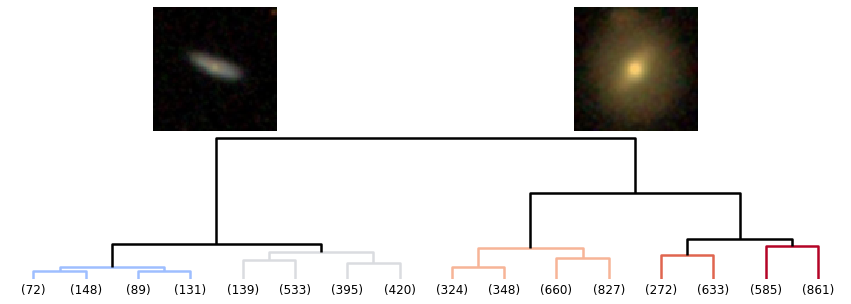

In [24]:
n_leaf_images = 16
span = 10

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(span, n_leaf_images)

ax_dendro = fig.add_subplot(gs[5:span, :])

# plotting the final two images (i.e. representative for 2 clusters)
ax_tt = []
ax_tt.append(fig.add_subplot(gs[0:4, :int(n_leaf_images / 2)]) )
ax_tt.append(fig.add_subplot(gs[0:4, int(n_leaf_images / 2):]) )
ax_tt = np.array(ax_tt)

for i, ax in enumerate(ax_tt):
    ax.imshow(x[np.argmax(agglo_2.labels_ == i)])
    ax.axis('off')

# plotting structure of dendrogram
param = cluster_evaluate.plot_dendrogram(agglo_2, 
                                        truncate_mode='level', p=3,
                                        ax = ax_dendro,
                                        color_threshold = 5, above_threshold_color = 'k',
                                        leaf_font_size = 12, leaf_rotation=0,
                                        orientation='top',
                                        count_sort=True, 
                                        show_leaf_counts = True)
#ax_dendro.axis('off')
ax_dendro.axes.get_yaxis().set_visible(False)
ax_dendro.spines['top'].set_visible(False)
ax_dendro.spines['bottom'].set_visible(False)
ax_dendro.spines['left'].set_visible(False)
ax_dendro.spines['right'].set_visible(False)
#ax_dendro.set_xlabel('Number of leaves (original samples) in branch', fontsize = 20)

fig.subplots_adjust(wspace = 0.1, hspace= -0.5)
plt.savefig(plot_path+'dendrogram-n16.png', format='png', dpi=200, bbox_inches='tight')

### Creating n=32 agglomerative clustering to save for output.

In [6]:
# defining k=2 tree
agglo_32 = AgglomerativeClustering(n_clusters=32,
                                   linkage='ward')
agglo_32.fit_predict(features) ;

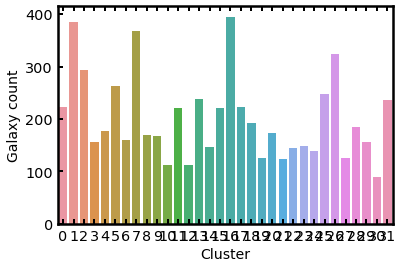

In [7]:
fig = plt.figure()
ax = fig.add_subplot()

sns.countplot(x=agglo_32.labels_, ax=ax)
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Galaxy count', fontsize=14)
plt.savefig(plot_path + 'cluster_countplot.png', format='png', 
            bbox_inches='tight', dpi=200)

In [10]:
for cl in np.unique(agglo_32.labels_):
    cluster_evaluate.save_cluster_plot(images = x[agglo_32.labels_ == cl], 
                                       cluster_number = cl,
                                       cluster_total= agglo_32.n_clusters - 1,
                                       plot_path= plot_path) ;
    plt.close()

### Saving cluster labels to file

In [11]:
label_path = './cluster_tags/'
np.save(label_path + 'agglomerative-' + str(agglo_32.n_clusters) + '_CNN-' + str(cnn_feat) + '_PCA-' + str(pca_feat) + '.npy', 
        agglo_32.labels_)